# Imports

In [613]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling, MaxPooling2D, Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Reading the dataset

In [ ]:
DATA_DIR = 'data'

In [614]:
# Setting the train and test directory path
TRAIN_DIR_PATH = os.path.join(DATA_DIR, 'training_set')
TEST_DIR_PATH = os.path.join(DATA_DIR, 'test_set')

In [615]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

In [616]:
# Getting the train and test dataset into tensorflow batches
train_batches = image_dataset_from_directory(TRAIN_DIR_PATH,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE,
                                             shuffle=True,
                                             seed=123,
                                             validation_split=0.2,
                                             subset='training')

val_batches = image_dataset_from_directory(directory=TRAIN_DIR_PATH,
                                           batch_size=BATCH_SIZE,
                                           image_size=IMAGE_SIZE,
                                           shuffle=True,
                                           validation_split=0.2,
                                           subset='validation',
                                           seed=123)

test_batches = image_dataset_from_directory(TEST_DIR_PATH,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMAGE_SIZE,
                                            shuffle=True,
                                            seed=123)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Found 2023 files belonging to 2 classes.


In [617]:
# Batch distribution
print(f'No. of training batches: {len(train_batches)}')
print(f'No. of validation batches: {len(val_batches)}')
print(f'No. of testing batches: {len(test_batches)}')

No. of training batches: 201
No. of validation batches: 51
No. of testing batches: 64


# Plotting some images

CPU times: user 453 ms, sys: 31.4 ms, total: 484 ms
Wall time: 423 ms


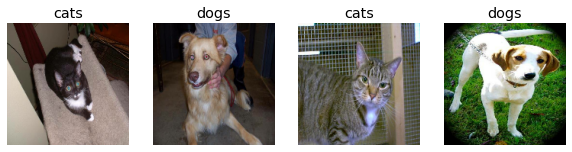

In [618]:
%%time
class_names = train_batches.class_names
plt.figure(figsize=(10,10))
for images, labels in train_batches.take(1):
    for i in range(4):
        ax = plt.subplot(1,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Configure dataset for performance

In [619]:
# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_batches.prefetch(buffer_size=AUTOTUNE)
val_ds = val_batches.prefetch(buffer_size=AUTOTUNE)
test_ds = test_batches.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [620]:
data_augmentation = tf.keras.Sequential([
    RandomFlip(mode='horizontal'),
    RandomRotation(factor=0.3)
])

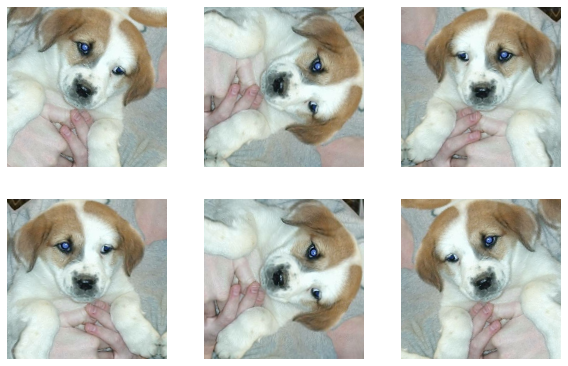

In [621]:
# Plotting some images in data augmentation
for images, _ in train_ds.take(1):
    first_image = images[0]
    plt.figure(figsize=(10,10))
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

# Rescaling pixel values

In [623]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
valid_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Building deep learning model

In [624]:
# Getting and initializing pre-trained model
INPUT_SHAPE = IMAGE_SIZE + (3,)
base_model = ResNet50(include_top=False,
                      weights='imagenet',
                      input_shape=INPUT_SHAPE)

In [626]:
base_model.trainable = False

In [627]:
# base_model.summary()

In [629]:
# Initializing model and adding layers
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))
model.add(data_augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [630]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy'])

In [631]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_47 (Sequential)   (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_28  (None, 2048)              0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________



# Training

In [632]:
EPOCHS = 20
CALLBACKS = [EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='auto')]

In [633]:
%%time
hist = model.fit(train_ds, 
                 epochs=EPOCHS,
                 validation_data=valid_ds,
                 callbacks=CALLBACKS)

Epoch 1/20
201/201 [==============================] - 23s 98ms/step - loss: 0.5232 - accuracy: 0.7459 - val_loss: 0.2022 - val_accuracy: 0.9269
Epoch 2/20
201/201 [==============================] - 21s 104ms/step - loss: 0.2845 - accuracy: 0.8773 - val_loss: 0.1349 - val_accuracy: 0.9532
Epoch 3/20
201/201 [==============================] - 21s 102ms/step - loss: 0.2315 - accuracy: 0.9043 - val_loss: 0.1075 - val_accuracy: 0.9606
Epoch 4/20
201/201 [==============================] - 19s 94ms/step - loss: 0.2045 - accuracy: 0.9152 - val_loss: 0.1022 - val_accuracy: 0.9606
Epoch 5/20
201/201 [==============================] - 19s 96ms/step - loss: 0.1903 - accuracy: 0.9210 - val_loss: 0.0918 - val_accuracy: 0.9644
Epoch 6/20
201/201 [==============================] - 20s 95ms/step - loss: 0.1736 - accuracy: 0.9271 - val_loss: 0.0888 - val_accuracy: 0.9638
Epoch 7/20
201/201 [==============================] - 19s 93ms/step - loss: 0.1688 - accuracy: 0.9324 - val_loss: 0.0830 - val_accurac

# Plotting the loss and accuracy

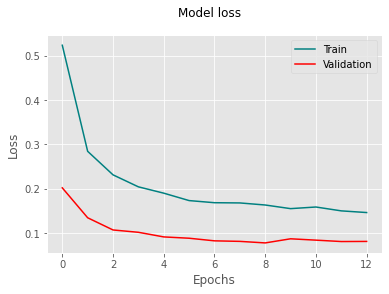

In [634]:
# Plotting the training loss and validation loss
plt.plot(hist.history['loss'], color='teal', label='Train')
plt.plot(hist.history['val_loss'], color='red', label='Validation')
plt.suptitle('Model loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

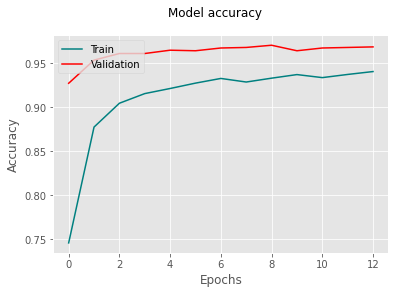

In [635]:
# Plotting the training accuracy and validation accuracy
plt.plot(hist.history['accuracy'], color='teal', label='Train')
plt.plot(hist.history['val_accuracy'], color='red', label='Validation')
plt.legend(loc='upper left')
plt.suptitle('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Evaluating the accuracy

In [636]:
# Evaluating the test_dataset
test_accuracy = model.evaluate(test_ds)[1]
print(f'Test Accuracy : {test_accuracy:.2f}')

64/64 [==============================] - 5s 72ms/step - loss: 0.0718 - accuracy: 0.9703
Test Accuracy : 0.97


In [637]:
%%time
x_test, y_test = test_batches.as_numpy_iterator().next()

for img, lbl in test_batches.as_numpy_iterator():
    x_test = np.append(x_test, img, axis=0)
    y_test = np.append(y_test, lbl, axis=0)

CPU times: user 7.48 s, sys: 4.2 s, total: 11.7 s
Wall time: 9.04 s


In [638]:
y_hat = model.predict(x_test)
y_hat = tf.where(y_hat < 0.5, 0, 1)

In [639]:
# Classification report
print(classification_report(y_test, y_hat, target_names=['Cat','Dog']))

              precision    recall  f1-score   support

         Cat       0.99      0.88      0.93      1026
         Dog       0.89      0.99      0.94      1029

    accuracy                           0.94      2055
   macro avg       0.94      0.94      0.94      2055
weighted avg       0.94      0.94      0.94      2055



In [640]:
from sklearn.metrics import f1_score
f1_score(y_test, y_hat)

0.9400921658986175